# getAnnualEmissionsIntensity
This script plots time series of emissions intensity for individual units, and calculates emissions intensity for each unit in the Western Interconnection.

In [2]:
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

import _02_plotStyles
import _01_accessData

### Enter database access credentials here.

In [3]:
def getDataByYear(orispl, unit, year):
    query = "SELECT \
                gload, \
                heat_input, \
                CO2_MASS, \
                SO2_MASS, \
                NOX_MASS, \
                CAST(gload as DECIMAL(8))*CAST(op_time as DECIMAL(8)) as gen, \
                (CAST(gload as DECIMAL(8))*CAST(op_time as DECIMAL(8)))/(CAST(heat_input as DECIMAL(8))*0.29307107) as efficiency \
            FROM \
                widap.data \
            WHERE ORISPL_CODE = " + str(orispl) + " AND UNITID = '" + str(unit) + "' \
            AND SUBSTR(OP_DATE, 1, 4) = " + str(year) #"'2017'"
    
    HRCdata = pd.read_sql(query, server)
#     print(HRCdata.shape)
#     HRCdata = HRCdata.dropna()
#     print(HRCdata.shape)
    return HRCdata

In [5]:
def calcAvgEIChanges_sum(orispl, unit, year1, year2):
    # inputs: orispl, unit, year1 (baseline), year 2 (end year)
    year1 = getDataByYear(orispl, unit, year1)
    year2 = getDataByYear(orispl, unit, year2)

    # filter for off, NaNs
    year1 = year1[year1['gen'] > 0.1]
    year2 = year2[year2['gen'] > 0.1]

    year1 = year1[year1['efficiency'].isna() != True]
    year2 = year2[year2['efficiency'].isna() != True]
        
    for metric in ['CO2_MASS', 'SO2_MASS', 'NOX_MASS']:
        # filter outliers, spinning reserves?
        
        sum1 = year1[metric].sum()
        sum2 = year1['gen'].sum()
        ratio = sum1/sum2
        mean1 = ratio.mean()

        sum1 = year2[metric].sum()
        sum2 = year2['gen'].sum()
        ratio = sum1/sum2
        mean2 = ratio.mean()

        diff = mean2 - mean1
        pcDiff = 100*diff/mean1
        print('Delta', metric, '(%): ', pcDiff)

##### Intermountain Exaple: Large, baseload coal that changed to load-following
1918 MW

Millard County, Utah

In [6]:
calcAvgEIChanges_sum(6481, '1SGA', 2005, 2017)

Delta CO2_MASS (%):  -12.917581841442002
Delta SO2_MASS (%):  3.6754400360278026
Delta NOX_MASS (%):  -41.06990613846181


##### Fort St. Vrain Example: Gas plant that increased variance and lowered CF slightly
1050 MW
Weld County, Colorado

In [7]:
calcAvgEIChanges_sum(6112, '2', 2001, 2017)

Delta CO2_MASS (%):  -2.015191314555947
Delta SO2_MASS (%):  -2.00760078103204
Delta NOX_MASS (%):  -22.669959826674724


##### Jim Bridger: Large coal plant with moderate increase in var, decrease in CF

In [8]:
calcAvgEIChanges_sum(8066, 'BW71', 2001, 2017)

Delta CO2_MASS (%):  -7.112929879174809
Delta SO2_MASS (%):  -53.077545127987506
Delta NOX_MASS (%):  -58.46517457728634


### Change to range of years, rather than single year identifier

In [9]:
def getYears(orispl, unit, start_year, stop_year):
    query = "SELECT \
                SUBSTR(OP_DATE, 1, 4) as year, \
                CO2_MASS, \
                SO2_MASS, \
                NOX_MASS, \
                CAST(gload as DECIMAL(8))*CAST(op_time as DECIMAL(8)) as gen, \
                gload, \
                heat_input, \
                (CAST(gload as DECIMAL(8))*CAST(op_time as DECIMAL(8)))/(CAST(heat_input as DECIMAL(8))*0.29307107) as efficiency \
            FROM \
                widap.data \
            WHERE ORISPL_CODE = " + str(orispl) + " AND UNITID = '" + str(unit) + "' \
            AND SUBSTR(OP_DATE, 1, 4) BETWEEN " + str(start_year) + " AND " + str(stop_year)
    
    HRCdata = pd.read_sql(query, server)
#     print(HRCdata.shape)
#     HRCdata = HRCdata.dropna()
#     print(HRCdata.shape)
    return HRCdata

In [10]:
def calcAvgEIChanges_span(orispl, unit, data1, data2):
    # inputs: orispl, unit, data for first range of years, data for second range of years
    # filter for off, NaNs
    data1 = data1[data1['gen'] > 0.1]
    data2 = data2[data2['gen'] > 0.1]

    data1 = data1[data1['efficiency'].isna() != True]
    data2 = data2[data2['efficiency'].isna() != True]
        
    for metric in ['CO2_MASS', 'SO2_MASS', 'NOX_MASS']:
        # filter outliers, spinning reserves?
        
        sum1 = data1[metric].sum()
        sum2 = data1['gen'].sum()
        ratio = sum1/sum2
        mean1 = ratio.mean()

        sum1 = data2[metric].sum()
        sum2 = data2['gen'].sum()
        ratio = sum1/sum2
        mean2 = ratio.mean()

        diff = mean2 - mean1
        pcDiff = 100*diff/mean1
        print('Delta', metric, '(%): ', pcDiff)

Jim Bridger

In [11]:
before = getYears(8066, 'BW71', 2001, 2009)

In [12]:
after = getYears(8066, 'BW71', 2012, 2018)

In [13]:
calcAvgEIChanges_span(8066, 'BW71', before, after)

Delta CO2_MASS (%):  -5.6771745157142295
Delta SO2_MASS (%):  -51.901901154588764
Delta NOX_MASS (%):  -56.956542119569676


Intermountain

In [14]:
before = getYears(6481, '1SGA', 2001, 2009)

In [15]:
after = getYears(6481, '1SGA', 2012, 2018)

In [16]:
calcAvgEIChanges_span(6481, '1SGA', before, after)

Delta CO2_MASS (%):  -8.514746796268218
Delta SO2_MASS (%):  11.67719646111621
Delta NOX_MASS (%):  -16.95576624635344


### Plot of EI over time span of data

In [17]:
def getAllYears(orispl, unit):
    query = "SELECT \
                SUBSTR(OP_DATE, 1, 4) as year, \
                CO2_MASS, \
                SO2_MASS, \
                NOX_MASS, \
                CAST(gload as DECIMAL(8))*CAST(op_time as DECIMAL(8)) as gen, \
                gload, \
                heat_input, \
                (CAST(gload as DECIMAL(8))*CAST(op_time as DECIMAL(8)))/(CAST(heat_input as DECIMAL(8))*0.29307107) as efficiency \
            FROM \
                widap.data \
            WHERE ORISPL_CODE = " + str(orispl) + " AND UNITID = '" + str(unit) + "'"
    data = pd.read_sql(query, server)
    data['year'] = data['year'].astype('int32', copy=False)
    return data

In [93]:
def get_emissions_generation(orispl, unit):
    query = "SELECT SUBSTR(OP_DATE, 1, 4) as year, \
                    SUM(CO2_MASS) as CO2_MASS, \
                    SUM(SO2_MASS) as SO2_MASS, \
                    SUM(NOX_MASS) as NOX_MASS, \
                    SUM(GLOAD*OP_TIME) as gen \
             FROM widap.data \
             WHERE ORISPL_CODE = " + str(orispl) + " AND UNITID = '" + str(unit) + "' \
             GROUP BY SUBSTR(OP_DATE, 1, 4) \
             ORDER BY SUBSTR(OP_DATE, 1, 4);"

    data = pd.read_sql(query, server)
    data['year'] = data['year'].astype('int32', copy=False)
    return data

In [19]:
def plotAllYears(orispl, unit):
    data = getAllYears(orispl, unit)
    data = data.dropna(subset=['gen', 'efficiency'])
    
    start = int(data['year'].min())
    stop = int(data['year'].max())
    years = range(start, stop + 1)
    
    co2 = np.zeros((len(years)))
    so2 = np.zeros((len(years)))
    nox = np.zeros((len(years)))
    for year in years:
        for metric in ['CO2_MASS', 'SO2_MASS', 'NOX_MASS']:
            tol = 1e-6
            subdata = data[abs(data['year'] - year) < tol]
            sum1 = subdata[metric].sum() # [tons for CO2, lbs for SO2, NOx]
            sum2 = subdata['gen'].sum()  # [MWh]
            ratio = sum1/sum2
            if metric == 'CO2_MASS': 
                co2[years.index(year)] = ratio
            elif metric == 'SO2_MASS':
                so2[years.index(year)] = ratio
            else:
                nox[years.index(year)] = ratio
    fig, ax1 = plt.subplots(figsize=(12, 7))
    # co2
    ax1.plot(years, co2, 'b', label='CO2')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('CO2 Intensity [tons/MWh]', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_ylim([0.8, 1.5])
    plt.xticks(np.arange(start, stop, step=2))
    plt.title('Emissions Intensities [Mass / MWh]: ' + str(orispl) + '_' + str(unit))
    # so2, nox
    ax2 = ax1.twinx()
    ax2.plot(years, so2, 'k--', label='SO2')
    ax2.plot(years, nox, 'k', label='NOX')
    ax2.set_ylabel('SO2, NOX Intensity [lbs/Mwh]')
    ax2.tick_params('y')
    ax2.set_ylim([0, 8])
    plt.legend()
    fig.tight_layout()
    plt.savefig("EI/EI_" + str(orispl) + "_" + str(unit) + ".png", dpi=1000, bbox_inches="tight")
    plt.show()

Intermountain

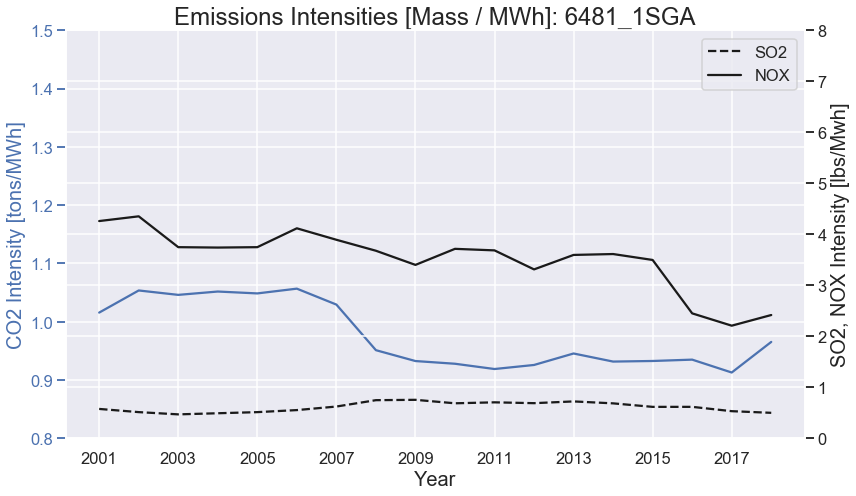

In [20]:
plotAllYears(6481, '1SGA')

Jim Bridger

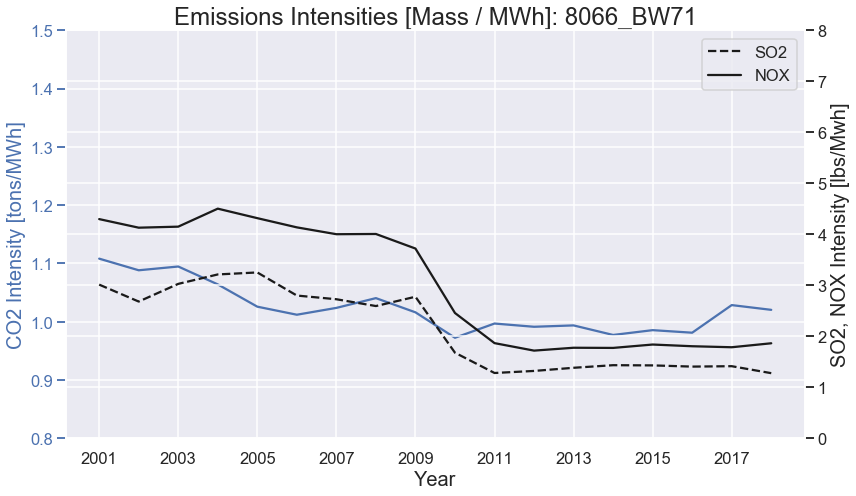

In [21]:
plotAllYears(8066, 'BW71')

Laramie River

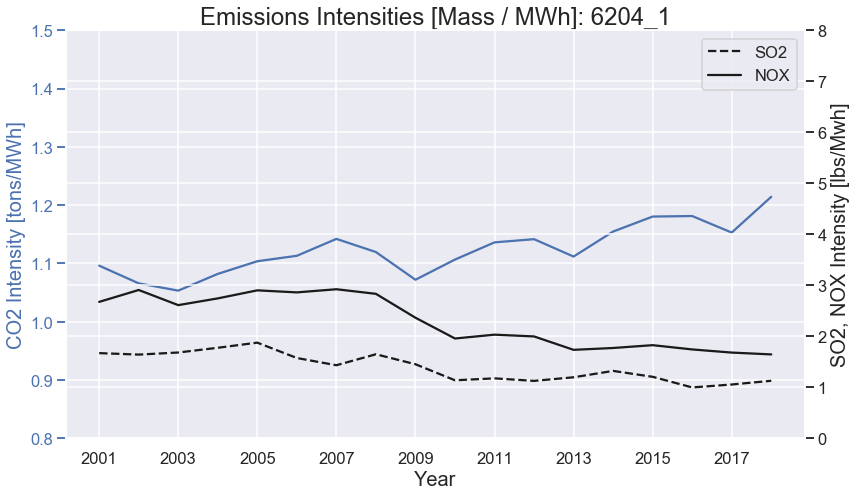

In [22]:
plotAllYears(6204, '1')

Colstrip

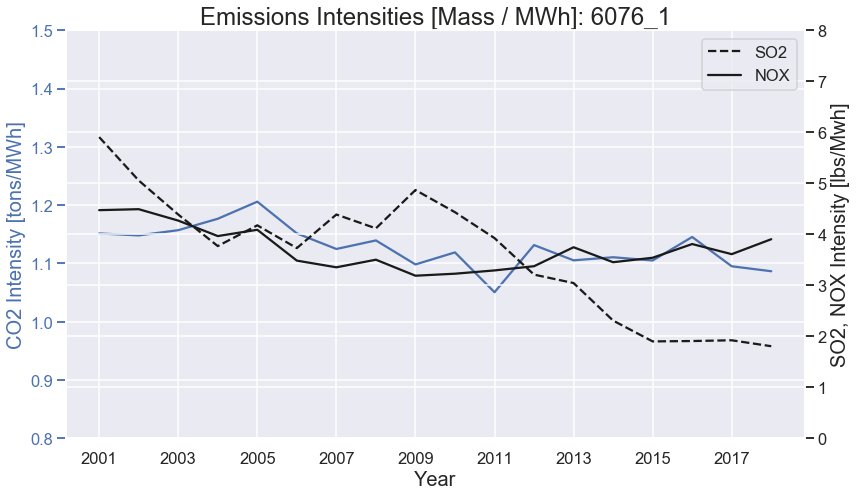

In [23]:
plotAllYears(6076, '1')

Navajo Generating Station

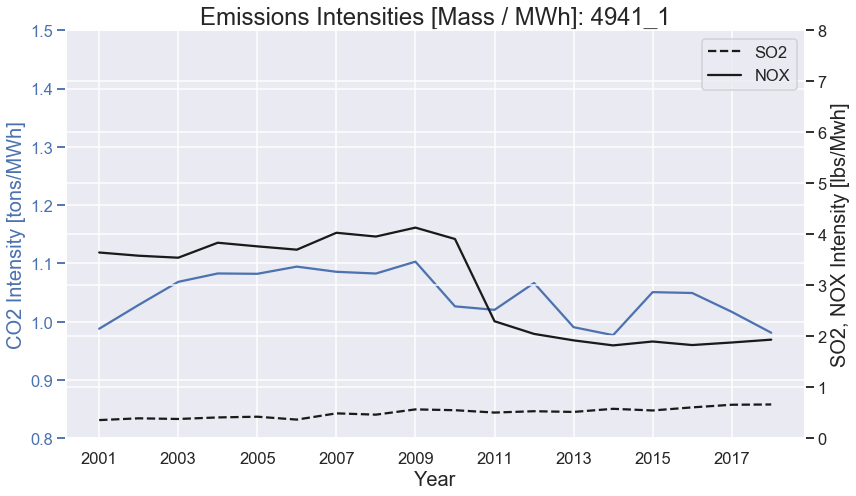

In [24]:
plotAllYears(4941, '1')

In [25]:
coal_units = pd.read_csv('C:/Users/apark2/Documents/Year 2/Research/Analysis/coal_labels_laptop.csv')
coal_units.head()

,Unnamed: 0,orispl_code,unitid,name,latitude,longitude,county,state,total_gen,capacity
0,0,87,1,Escalante,35.4159,-108.0820,McKinley,NM,27886837,273
1,1,113,1,Cholla,34.9394,-110.3033,Navajo,AZ,13573545,132
2,2,113,2,Cholla,34.9394,-110.3033,Navajo,AZ,29133162,306
3,3,113,3,Cholla,34.9394,-110.3033,Navajo,AZ,30366954,307
4,4,113,4,Cholla,34.9394,-110.3033,Navajo,AZ,46565885,436


#### All coal plants

##### Recall: If utilities have hydro assets, that's what they'll use for spin. It's the cheapest easily rampable energy.

##### Save data on emissions intensity vs year for all plants

In [29]:
def saveEI(plantDF):
    # This function extracts emissions intensity for each (plant, unit) row in the plant df passed.
    # It saves the results in a csv.
    cols = ['ORISPL_CODE', 'UNITID', 'NAME', 'FUEL', 'GAS', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
    toSave = pd.DataFrame(index=range(3*plantDF.shape[0]), columns=cols)
    toSave.fillna(-1)  # should fill entire dataframe with -1 (no data flag)
    endOfMetadata = cols.index('2001')
    
    for i, plant in plantDF.iterrows():
        plantUnit = tuple((plant[0], plant[1]))
        print(plant[2], ': ', plantUnit)
        data = getAllYears(*plantUnit)
        data = data.dropna(subset=['gen', 'efficiency'])
        
        # fill metadata
        label = [plant[0], plant[1], plant[2], plant[-1]]            
        toSave.iloc[3*i, :endOfMetadata] = label + ['CO2']
        toSave.iloc[3*i + 1, :endOfMetadata] = label + ['SO2']
        toSave.iloc[3*i + 2, :endOfMetadata] = label + ['NOX']
        
        if data.shape[0] == 0:
            continue
        else:
            start = int(data['year'].min())
            stop = int(data['year'].max())
            years = range(start, stop + 1)

            co2 = np.zeros((len(years)))
            so2 = np.zeros((len(years)))
            nox = np.zeros((len(years)))
            for year in years:
                for metric in ['CO2_MASS', 'SO2_MASS', 'NOX_MASS']:
                    tol = 1e-6
                    subdata = data[abs(data['year'] - year) < tol]
                    sum1 = subdata[metric].sum() # [tons for CO2, lbs for SO2, NOx]
                    sum2 = subdata['gen'].sum()  # [MWh]
                    ratio = sum1/sum2
                    if metric == 'CO2_MASS': 
                        co2[years.index(year)] = ratio
                    elif metric == 'SO2_MASS':
                        so2[years.index(year)] = ratio
                    else:
                        nox[years.index(year)] = ratio  
            # Add 3 rows. One row for each gas.
            startCol = endOfMetadata + start - 2001  # col iloc
            stopCol =  endOfMetadata + start - 2001 + len(years)

            toSave.iloc[3*i, startCol:stopCol] = co2
            toSave.iloc[3*i + 1, startCol:stopCol] = so2
            toSave.iloc[3*i + 2, startCol:stopCol] = nox
    toSave.to_csv('emissionsIntensity_V2.csv', index=False)
    return

In [92]:
WI_units = pd.read_csv('C:/Users/apark2/Documents/Year 2/Research/Analysis/Heat Rate Work/WI_units.csv')
# saveEI(WI_units)
WI_units.head()

,orispl_code,unitid,name,latitude,longitude,county,state,total_gen,capacity,fuel
0,87,1,Escalante,35.4159,-108.0820,McKinley,NM,27886837,273,coal
1,113,1,Cholla,34.9394,-110.3033,Navajo,AZ,13573545,132,coal
2,113,2,Cholla,34.9394,-110.3033,Navajo,AZ,29133162,306,coal
3,113,3,Cholla,34.9394,-110.3033,Navajo,AZ,30366954,307,coal
4,113,4,Cholla,34.9394,-110.3033,Navajo,AZ,46565885,436,coal


In [95]:
def save_emissions_generation(plantDF):
    # This function extracts emissions intensity for each (plant, unit) row in the plant df passed.
    # It saves the results in a csv.
    cols = ['ORISPL_CODE', 'UNITID', 'NAME', 'STATE', 'FUEL', 'GAS', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
    toSave = pd.DataFrame(index=range(4*plantDF.shape[0]), columns=cols)
    toSave.fillna(-1)  # should fill entire dataframe with -1 (no data flag)
    endOfMetadata = cols.index('2001')
    years = range(2001, 2019)
    
    for i, plant in plantDF.iterrows():
        plantUnit = tuple((plant[0], plant[1]))
        data = get_emissions_generation(*plantUnit)
        print(plant[2], ': ', plantUnit, '| shape: ', data.shape)
        
        # fill metadata
        label = [plant[0], plant[1], plant[2], plant[6], plant[-1]]
        toSave.iloc[4*i, :endOfMetadata] = label + ['CO2']
        toSave.iloc[4*i + 1, :endOfMetadata] = label + ['SO2']
        toSave.iloc[4*i + 2, :endOfMetadata] = label + ['NOX']
        toSave.iloc[4*i + 3, :endOfMetadata] = label + ['gen']
        
        if data.shape[0] == 0:
            continue
        else:
            j = 0
            for year in data['year']:
                ind = endOfMetadata + years.index(year)
                toSave.iloc[4*i, ind] = data['CO2_MASS'][j]
                toSave.iloc[4*i + 1, ind] = data['SO2_MASS'][j]
                toSave.iloc[4*i + 2, ind] = data['NOX_MASS'][j]
                toSave.iloc[4*i + 3, ind] = data['gen'][j]
                j += 1
    toSave.to_csv('annual_emissions_generation.csv', index=False)
    return

In [96]:
save_emissions_generation(WI_units)

Escalante  :  (87, '1') | shape:  (18, 5)
Cholla :  (113, '1') | shape:  (18, 5)
Cholla :  (113, '2') | shape:  (15, 5)
Cholla :  (113, '3') | shape:  (18, 5)
Cholla :  (113, '4') | shape:  (18, 5)
Irvington Generating Station :  (126, '4') | shape:  (18, 5)
Apache Station :  (160, '2') | shape:  (18, 5)
Apache Station :  (160, '3') | shape:  (18, 5)
Arapahoe :  (465, '1') | shape:  (2, 5)
Arapahoe :  (465, '2') | shape:  (2, 5)
Arapahoe :  (465, '3') | shape:  (13, 5)
Arapahoe :  (465, '4') | shape:  (13, 5)
Cameo :  (468, '2') | shape:  (10, 5)
Cherokee :  (469, '1') | shape:  (12, 5)
Cherokee :  (469, '2') | shape:  (11, 5)
Cherokee :  (469, '3') | shape:  (15, 5)
Cherokee :  (469, '4') | shape:  (18, 5)
Comanche (470) :  (470, '1') | shape:  (18, 5)
Comanche (470) :  (470, '2') | shape:  (18, 5)
Comanche (470) :  (470, '3') | shape:  (9, 5)
Valmont :  (477, '5') | shape:  (17, 5)
Martin Drake :  (492, '5') | shape:  (16, 5)
Martin Drake :  (492, '6') | shape:  (18, 5)
Martin Drake 

AES Alamitos :  (315, '2') | shape:  (18, 5)
AES Alamitos :  (315, '3') | shape:  (18, 5)
AES Alamitos :  (315, '4') | shape:  (18, 5)
AES Alamitos :  (315, '5') | shape:  (18, 5)
AES Alamitos :  (315, '6') | shape:  (18, 5)
Coolwater Generating Station :  (329, '1') | shape:  (15, 5)
Coolwater Generating Station :  (329, '2') | shape:  (15, 5)
Coolwater Generating Station :  (329, '31') | shape:  (15, 5)
Coolwater Generating Station :  (329, '32') | shape:  (15, 5)
Coolwater Generating Station :  (329, '41') | shape:  (15, 5)
Coolwater Generating Station :  (329, '42') | shape:  (15, 5)
El Segundo :  (330, '3') | shape:  (13, 5)
El Segundo :  (330, '4') | shape:  (15, 5)
El Segundo :  (330, '5') | shape:  (6, 5)
El Segundo :  (330, '7') | shape:  (6, 5)
Etiwanda Generating Station :  (331, '1') | shape:  (3, 5)
Etiwanda Generating Station :  (331, '2') | shape:  (3, 5)
Etiwanda Generating Station :  (331, '3') | shape:  (18, 5)
Etiwanda Generating Station :  (331, '4') | shape:  (18, 

Centralia :  (3845, '50') | shape:  (13, 5)
Centralia :  (3845, '60') | shape:  (13, 5)
Olive :  (6013, '1') | shape:  (0, 5)
Olive :  (6013, '2') | shape:  (0, 5)
Fort St. Vrain :  (6112, '2') | shape:  (18, 5)
Fort St. Vrain :  (6112, '3') | shape:  (18, 5)
Fort St. Vrain :  (6112, '4') | shape:  (18, 5)
Fort St. Vrain :  (6112, '5') | shape:  (10, 5)
Fort St. Vrain :  (6112, '6') | shape:  (10, 5)
Rawhide Energy Station :  (6761, 'A') | shape:  (17, 5)
Rawhide Energy Station :  (6761, 'B') | shape:  (17, 5)
Rawhide Energy Station :  (6761, 'C') | shape:  (17, 5)
Rawhide Energy Station :  (6761, 'D') | shape:  (15, 5)
Rawhide Energy Station :  (6761, 'F') | shape:  (11, 5)
Harry Allen :  (7082, '**3') | shape:  (18, 5)
Harry Allen :  (7082, '**4') | shape:  (13, 5)
Harry Allen :  (7082, '**5') | shape:  (8, 5)
Harry Allen :  (7082, '**6') | shape:  (8, 5)
Woodland Generation Station :  (7266, '1') | shape:  (18, 5)
Woodland Generation Station :  (7266, '2') | shape:  (16, 5)
Redding 

Chuck Lenzie Generating Station :  (55322, 'CTG-3') | shape:  (13, 5)
Chuck Lenzie Generating Station :  (55322, 'CTG-4') | shape:  (13, 5)
Hermiston Power Plant :  (55328, 'CTG-1') | shape:  (17, 5)
Hermiston Power Plant :  (55328, 'CTG-2') | shape:  (17, 5)
Delta Energy Center, LLC :  (55333, '1') | shape:  (17, 5)
Delta Energy Center, LLC :  (55333, '2') | shape:  (17, 5)
Delta Energy Center, LLC :  (55333, '3') | shape:  (17, 5)
Luna Energy Facility :  (55343, 'CTG1') | shape:  (13, 5)
Luna Energy Facility :  (55343, 'CTG2') | shape:  (13, 5)
Otay Mesa Energy Center, LLC :  (55345, 'CTG-1') | shape:  (10, 5)
Otay Mesa Energy Center, LLC :  (55345, 'CTG-2') | shape:  (10, 5)
New Harquahala Generating Company, LLC :  (55372, 'CTG1') | shape:  (16, 5)
New Harquahala Generating Company, LLC :  (55372, 'CTG2') | shape:  (16, 5)
New Harquahala Generating Company, LLC :  (55372, 'CTG3') | shape:  (16, 5)
Metcalf Energy Center :  (55393, '1') | shape:  (14, 5)
Metcalf Energy Center :  (553

Donald Von Raesfeld :  (56026, 'PCT2') | shape:  (13, 5)
Malburg Generating Station :  (56041, 'M1') | shape:  (14, 5)
Malburg Generating Station :  (56041, 'M2') | shape:  (14, 5)
Magnolia (SCPPA) :  (56046, '1') | shape:  (14, 5)
Walnut Energy Center :  (56078, '1') | shape:  (13, 5)
Walnut Energy Center :  (56078, '2') | shape:  (13, 5)
Currant Creek Power Project :  (56102, 'CTG1A') | shape:  (14, 5)
Currant Creek Power Project :  (56102, 'CTG1B') | shape:  (14, 5)
Ripon Generation Station :  (56135, '1') | shape:  (13, 5)
Ripon Generation Station :  (56135, '2') | shape:  (13, 5)
Riverside Energy Resource Center :  (56143, '1') | shape:  (13, 5)
Riverside Energy Resource Center :  (56143, '2') | shape:  (13, 5)
Riverside Energy Resource Center :  (56143, '3') | shape:  (8, 5)
Riverside Energy Resource Center :  (56143, '4') | shape:  (9, 5)
Nebo Power Station :  (56177, 'U1') | shape:  (15, 5)
Port Westward :  (56227, 'PWEU1') | shape:  (12, 5)
Miramar Energy Facility :  (56232, '

In [86]:
cols = ['ORISPL_CODE', 'UNITID', 'NAME', 'FUEL', 'GAS', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
toSave = pd.DataFrame(index=range(4*WI_units.shape[0]), columns=cols)
toSave.fillna(-1)  # should fill entire dataframe with -1 (no data flag)
endOfMetadata = cols.index('2001')


data = get_emissions_generation(3456, 'GT-6A')

# fill metadata
print(data.shape)

# start = int(data['year'].min())
# stop = int(data['year'].max())
years = range(2001, 2019)

print(start)
print(stop)
print(data['year'].values)
print([years.index(year) for year in data['year']])

startCol = endOfMetadata + start - 2001  # col iloc
stopCol =  endOfMetadata + start - 2001 + len(years)
i = 0
j = 0
for year in data['year']:
    ind = endOfMetadata + years.index(year)
    toSave.iloc[3*i, ind] = data['CO2_MASS'][j]
    toSave.iloc[3*i + 1, ind] = data['SO2_MASS'][j]
    toSave.iloc[3*i + 2, ind] = data['NOX_MASS'][j]
    toSave.iloc[3*i + 3, ind] = data['gen'][j]
    j += 1
print(toSave.iloc[0, :])
print(toSave.iloc[3, :])

(12, 5)
2002
2018
[2002 2006 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
[1, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
ORISPL_CODE        NaN
UNITID             NaN
NAME               NaN
FUEL               NaN
GAS                NaN
2001               NaN
2002           2418.32
2003               NaN
2004               NaN
2005               NaN
2006               NaN
2007               NaN
2008               NaN
2009           31029.9
2010           40522.5
2011            242809
2012            334994
2013            379246
2014            208892
2015            138700
2016            124651
2017           50912.4
2018           40490.9
Name: 0, dtype: object
ORISPL_CODE        NaN
UNITID             NaN
NAME               NaN
FUEL               NaN
GAS                NaN
2001               NaN
2002           3395.85
2003               NaN
2004               NaN
2005               NaN
2006               NaN
2007               NaN
2008               NaN
2009           34171.6
2

In [33]:
WI_units.iloc[80:85, :]

,orispl_code,unitid,name,latitude,longitude,county,state,total_gen,capacity,fuel
80,7504,1,Neil Simpson II,44.2853,-105.3841,Campbell,WY,12055229,101,coal
81,7790,1,Bonanza,40.0864,-109.2844,Uintah,UT,61422085,507,coal
82,8066,BW71,Jim Bridger,41.7378,-108.7875,Sweetwater,WY,63203276,581,coal
83,8066,BW72,Jim Bridger,41.7378,-108.7875,Sweetwater,WY,63035522,585,coal
84,8066,BW73,Jim Bridger,41.7378,-108.7875,Sweetwater,WY,62249182,570,coal


In [34]:
cols = ['ORISPL_CODE', 'UNITID', 'NAME', 'FUEL', 'GAS', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
cols.index('2001')

5

##### Emissions intensities for all gas and all coal plants

In [35]:
def get_allYears_allUnits():
    query = """SELECT \
                SUBSTR(OP_DATE, 1, 4) as year, \
                SUM(CO2_MASS) / SUM(CAST(gload as DECIMAL(8))*CAST(op_time as DECIMAL(8))) as CO2I, \
                SUM(SO2_MASS) / SUM(CAST(gload as DECIMAL(8))*CAST(op_time as DECIMAL(8))) as SO2I, \
                SUM(NOX_MASS) / SUM(CAST(gload as DECIMAL(8))*CAST(op_time as DECIMAL(8))) as NOXI \
            FROM \
                widap.data \
            GROUP BY SUBSTR(OP_DATE, 1, 4)
            ORDER BY SUBSTR(OP_DATE, 1, 4)"""
    data = pd.read_sql(query, server)
    data['year'] = data['year'].astype('int32', copy=False)
    return data

In [101]:
def plot_allYears_allUnits():
    data = get_allYears_allUnits(orispl, unit)
    data = data.dropna(subset=['gen', 'efficiency'])
    
    start = int(data['year'].min())
    stop = int(data['year'].max())
    years = range(start, stop + 1)
    
    co2 = np.zeros((len(years)))
    so2 = np.zeros((len(years)))
    nox = np.zeros((len(years)))
    for year in years:
        for metric in ['CO2_MASS', 'SO2_MASS', 'NOX_MASS']:
            tol = 1e-6
            subdata = data[abs(data['year'] - year) < tol]
            sum1 = subdata[metric].sum() # [tons for CO2, lbs for SO2, NOx]
            sum2 = subdata['gen'].sum()  # [MWh]
            ratio = sum1/sum2
            if metric == 'CO2_MASS': 
                co2[years.index(year)] = ratio
            elif metric == 'SO2_MASS':
                so2[years.index(year)] = ratio
            else:
                nox[years.index(year)] = ratio
    fig, ax1 = plt.subplots(figsize=(12, 7))
    # co2
    ax1.plot(years, co2, 'b', label='CO2')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('CO2 Intensity [tons/MWh]', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_ylim([0.8, 1.5])
    plt.xticks(np.arange(start, stop, step=2))
    plt.title('Emissions Intensities [Mass / MWh]: ' + str(orispl) + '_' + str(unit))
    # so2, nox
    ax2 = ax1.twinx()
    ax2.plot(years, so2, 'k--', label='SO2')
    ax2.plot(years, nox, 'k', label='NOX')
    ax2.set_ylabel('SO2, NOX Intensity [lbs/Mwh]')
    ax2.tick_params('y')
    ax2.set_ylim([0, 8])
    plt.legend()
    fig.tight_layout()
    plt.savefig("EI/EI_" + str(orispl) + "_" + str(unit) + ".png", dpi=1000, bbox_inches="tight")
    plt.show()

In [102]:
EI_aggregated = get_allYears_allUnits()

In [103]:
EI_aggregated

,year,CO2I,SO2I,NOXI
0,2001,0.892543,3.312404,2.683677
1,2002,0.905220,3.235404,2.497073
2,2003,0.907332,3.121528,2.285382
3,2004,0.891545,2.758821,2.079639
4,2005,0.849409,2.565326,1.930147
5,2006,0.825040,2.324624,1.785315
6,2007,0.804377,2.117722,1.653399
7,2008,0.799223,1.978935,1.525757
8,2009,0.773147,1.861615,1.401086
9,2010,0.784634,1.864638,1.355715


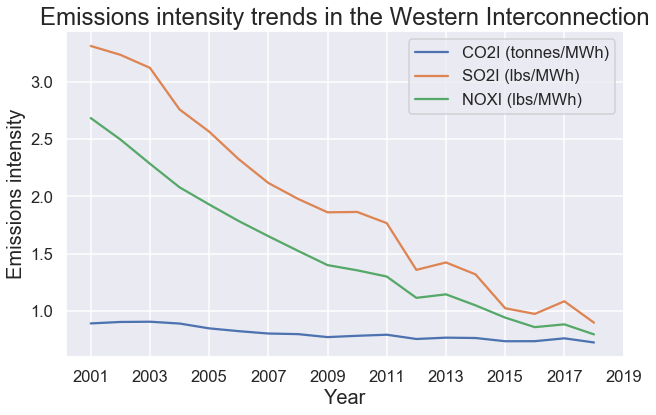

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(EI_aggregated['year'], EI_aggregated.iloc[:, 1:])
plt.legend(['CO2I (tonnes/MWh)','SO2I (lbs/MWh)','NOXI (lbs/MWh)'])
plt.xticks(np.linspace(2001, 2019, 10))
plt.title('Emissions intensity trends in the Western Interconnection')
plt.xlabel('Year')
plt.ylabel('Emissions intensity')
plt.show()

Downward trend in CO2 intensity is caused by fuel-switching from coal to gas. Separate by fuel type to see what they've done individually.